In [1]:
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster(
    n_workers=28,
    threads_per_worker=8,
    silence_logs=logging.DEBUG
)

client = Client(cluster, heartbeat_interval=10000)

print(client.dashboard_link)

/opt/tljh/user/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41751 instead
  http_address["port"], self.http_server.port
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:44297
distributed.scheduler - INFO -   dashboard at:           127.0.0.1:41751
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:33433'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:39029'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:39521'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:32807'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44805'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42975'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:37703'
distributed.nanny - INFO -         

http://127.0.0.1:41751/status


In [2]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [3]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/camcan_data",
    target_cols=["age"],
    index_col="Observations"
)

In [4]:
print(X.shape)
print(y.shape)
print(len(subjects))

(641, 3600)
(652,)
641


In [5]:
df_y = pd.read_csv("../data/raw/camcan_data/subjects.csv")
df_y.head()
df_y = df_y[["Observations", "age"]]
df_y = df_y.set_index("Observations", drop=True)
df_subs = pd.DataFrame(index=subjects)
df_subs = df_subs.merge(df_y, how="left", left_index=True, right_index=True)
y = df_subs["age"].astype(np.float64).values
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [6]:
print(X.shape)
print(y.shape)

(640, 3600)
(640,)


In [7]:
len(groups)

36

(array([26., 58., 72., 68., 76., 64., 71., 74., 86., 45.]),
 array([18., 25., 32., 39., 46., 53., 60., 67., 74., 81., 88.]),
 <BarContainer object of 10 artists>)

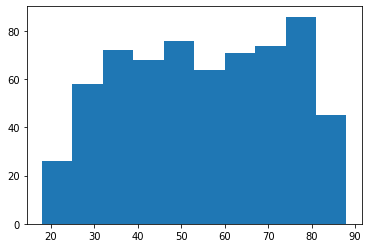

In [8]:
plt.hist(y)

In [9]:
np.median(y)

55.0

In [10]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10,
                   trim_nodes=0,
                   square_features=False):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
        
    if trim_nodes > 0:
        grp_mask = np.zeros_like(groups[0], dtype=bool)
        grp_mask[trim_nodes:-trim_nodes] = True
        X_mask = np.concatenate([grp_mask] * len(groups))

        groups_trim = []
        start_idx = 0
        
        for grp in groups:
            stop_idx = start_idx + len(grp) - 2 * trim_nodes
            groups_trim.append(np.arange(start_idx, stop_idx))
            start_idx += len(grp) - 2 * trim_nodes
            
        X_trim = X[:, X_mask]
    elif trim_nodes == 0:
        groups_trim = [grp for grp in groups]
        X_trim = np.copy(X)
    else:
        raise ValueError("trim_nodes must be non-negative.")
        
    if square_features:
        _n_samples, _n_features = X_trim.shape
        X_trim = np.hstack([X_trim, np.square(X_trim)])
        groups_trim = [np.concatenate([g, g + _n_features]) for g in groups_trim]
    
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.make_afq_regressor_pipeline(
        imputer_kwargs={"strategy": "median"},
        use_cv_estimator=True,
        power_transformer=power_transformer,
        scaler="standard",
        groups=groups_trim,
        verbose=0,
        pipeline_verbosity=False,
        tuning_strategy="bayes",
        cv=3,
        n_bayes_points=9,
        n_jobs=28,
        l1_ratio=[0.0, 1.0],
        eps=5e-2,
        n_alphas=100,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        with joblib.parallel_backend("dask"):
            pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ((target_transform_func is not None)
            or (target_transform_inverse_func is not None)):
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
            cv_results[cv_idx]["l1_ratio"] = [
                est.l1_ratio_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
        else:
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
            cv_results[cv_idx]["l1_ratio"] = [
                est.l1_ratio_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].regressor_.bayes_optimizer_                
            else:
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].bayes_optimizer_

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [11]:
results = {}

In [12]:
for trim_nodes in range(5):
    results[f"bagging_target_transform_trim{trim_nodes}"] = get_cv_results(
        n_splits=5, n_repeats=1, power_transformer=False,
        ensembler="serial-bagging", shuffle=False, n_estimators=20,
        target_transform_func=np.log, target_transform_inverse_func=np.exp,
        trim_nodes=trim_nodes, square_features=False,
    )

    results[f"bagging_trim{trim_nodes}"] = get_cv_results(
        n_splits=5, n_repeats=1, power_transformer=False,
        ensembler="serial-bagging", shuffle=False, n_estimators=20,
        trim_nodes=trim_nodes, square_features=False,
    )
    
    results[f"bagging_target_transform_trim{trim_nodes}_square_features"] = get_cv_results(
        n_splits=5, n_repeats=1, power_transformer=False,
        ensembler="serial-bagging", shuffle=False, n_estimators=20,
        target_transform_func=np.log, target_transform_inverse_func=np.exp,
        trim_nodes=trim_nodes, square_features=True,
    )

    results[f"bagging_trim{trim_nodes}_square_features"] = get_cv_results(
        n_splits=5, n_repeats=1, power_transformer=False,
        ensembler="serial-bagging", shuffle=False, n_estimators=20,
        trim_nodes=trim_nodes, square_features=True,
    )    

distributed.scheduler - INFO - Receive client connection: Client-worker-d361d73e-51b1-11eb-85b5-b70d5cbea419
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-d36165ee-51b1-11eb-8615-d1564b17a3b2
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-d3632192-51b1-11eb-8598-93943cb6c096
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-d363dc24-51b1-11eb-85a1-1f6b5b039197
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-d365b91e-51b1-11eb-8613-f7f55fe77c40
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-d364b6da-51b1-11eb-8613-42010a8a0002
distributed.core - INFO - Starting established connectio

CV index [  0], Elapsed time:  0:55:32.949095
CV index [  1], Elapsed time:  0:57:00.004010


distributed.core - INFO - Event loop was unresponsive in Nanny for 5.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  3], Elapsed time:  0:57:35.968975


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  4], Elapsed time:  0:58:43.275811


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  0], Elapsed time:  1:05:51.737940


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  1], Elapsed time:  1:04:38.117699


distributed.core - INFO - Event loop was unresponsive in Nanny for 5.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  2], Elapsed time:  1:03:40.774111


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  3], Elapsed time:  1:07:19.991631


distributed.core - INFO - Event loop was unresponsive in Nanny for 6.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  4], Elapsed time:  1:04:59.432889


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause t

CV index [  0], Elapsed time:  1:22:20.161204


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. Th

CV index [  1], Elapsed time:  1:18:23.963200


distributed.core - INFO - Event loop was unresponsive in Nanny for 11.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

CV index [  3], Elapsed time:  1:18:03.617743


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  3], Elapsed time:  1:27:23.129727


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  4], Elapsed time:  1:26:38.820673


distributed.core - INFO - Event loop was unresponsive in Nanny for 8.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  2], Elapsed time:  1:01:08.766246


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  1], Elapsed time:  1:10:03.872605


distributed.core - INFO - Event loop was unresponsive in Nanny for 12.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

CV index [  2], Elapsed time:  1:08:46.928768


distributed.core - INFO - Event loop was unresponsive in Nanny for 10.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of dat

CV index [  3], Elapsed time:  1:09:38.183119


distributed.core - INFO - Event loop was unresponsive in Nanny for 13.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

CV index [  3], Elapsed time:  1:26:14.057619


distributed.core - INFO - Event loop was unresponsive in Nanny for 15.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

CV index [  4], Elapsed time:  1:24:40.324115


distributed.core - INFO - Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  3], Elapsed time:  1:10:01.413945


distributed.core - INFO - Event loop was unresponsive in Nanny for 7.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  4], Elapsed time:  1:09:23.970159


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  0], Elapsed time:  1:19:03.306474
CV index [  3], Elapsed time:  0:53:21.041933


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  1], Elapsed time:  0:55:49.358377


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  2], Elapsed time:  0:55:00.891652


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/

CV index [  2], Elapsed time:  0:36:56.097810


distributed.core - INFO - Event loop was unresponsive in Nanny for 8.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  3], Elapsed time:  0:36:54.255337


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause t

CV index [  4], Elapsed time:  0:37:20.021662


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/

CV index [  0], Elapsed time:  0:39:04.226815


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  1], Elapsed time:  0:38:13.789027


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  4], Elapsed time:  0:39:13.838191


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  0], Elapsed time:  1:06:31.016703


distributed.core - INFO - Event loop was unresponsive in Nanny for 5.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  1], Elapsed time:  1:09:53.878140


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  2], Elapsed time:  1:09:14.579354


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. Th

CV index [  3], Elapsed time:  1:11:57.401505


distributed.core - INFO - Event loop was unresponsive in Nanny for 10.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

CV index [  4], Elapsed time:  1:10:25.241703


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. Th

CV index [  0], Elapsed time:  1:10:32.042725


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  1], Elapsed time:  1:10:02.356977


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  0], Elapsed time:  0:50:19.670225


distributed.core - INFO - Event loop was unresponsive in Nanny for 7.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  4], Elapsed time:  0:50:33.729463


distributed.core - INFO - Event loop was unresponsive in Nanny for 8.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  0], Elapsed time:  0:51:07.055434


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  1], Elapsed time:  0:51:51.932231


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  2], Elapsed time:  0:50:46.283396


distributed.core - INFO - Event loop was unresponsive in Nanny for 5.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  4], Elapsed time:  0:52:32.787275


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  0], Elapsed time:  1:08:23.119355


distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  3], Elapsed time:  1:09:00.468603


distributed.core - INFO - Event loop was unresponsive in Nanny for 6.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  4], Elapsed time:  1:09:55.697106


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instab

CV index [  0], Elapsed time:  1:09:18.843545


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instabil

CV index [  1], Elapsed time:  1:08:42.308178


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  2], Elapsed time:  1:09:33.599206


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  3], Elapsed time:  1:09:06.326293


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/

CV index [  4], Elapsed time:  1:09:45.644657


In [16]:
for key, res in results.items():
    test_mae = [cvr["test_mae"] for cvr in res[0].values()]
    train_mae = [cvr["train_mae"] for cvr in res[0].values()]
    test_r2 = [cvr["test_r2"] for cvr in res[0].values()]
    train_r2 = [cvr["train_r2"] for cvr in res[0].values()]

    print(key, "mean MAE", np.mean(test_mae))
    print(key, "std MAE", np.std(test_mae))
    print(key, "mean R2", np.mean(test_r2))
    print(key, "std R2", np.std(train_r2))

bagging_target_transform_trim0 mean MAE 6.98625085428297
bagging_target_transform_trim0 std MAE 0.39758721776486805
bagging_target_transform_trim0 mean R2 0.6561005945355033
bagging_target_transform_trim0 std R2 0.007689726350837976
bagging_trim0 mean MAE 6.123498636136497
bagging_trim0 std MAE 0.5116829047008166
bagging_trim0 mean R2 0.7666760055451672
bagging_trim0 std R2 0.0074493728571796425
bagging_target_transform_trim0_square_features mean MAE 7.138661065663996
bagging_target_transform_trim0_square_features std MAE 0.5916654984402284
bagging_target_transform_trim0_square_features mean R2 0.6219437339960543
bagging_target_transform_trim0_square_features std R2 0.006823122483493698
bagging_trim0_square_features mean MAE 6.3285344362706635
bagging_trim0_square_features std MAE 0.6602781262104904
bagging_trim0_square_features mean R2 0.7515358236493744
bagging_trim0_square_features std R2 0.00648273080771269
bagging_target_transform_trim1 mean MAE 7.55747183464874
bagging_target_tra

In [17]:
with open("camcan_regression_paper.pkl", "wb") as fp:
    pickle.dump(results, fp)